In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from matplotlib.colors import Normalize
from matplotlib.ticker import LogLocator, LogFormatter

In [94]:

columns = [
    "mode", "thread_num", "probe_size", "build_size", "selectivity", "payload_size",
    "probe_distribution", "build_side_hit_ratio", "build_key_pattern", "probe_key_pattern",
    "mat_strat", "queue_thr", "time"
]

# 读取文件并解析数据
data = []
with open('/home/yihao/duckdb/ht/duckdb/examples/embedded-c++/release/benchmark_time_0103.txt', 'r') as file:
    for line in file:
        # 将每行数据拆分为多个字段
        values = line.strip().split()
        # 将字段转换为适当的类型
        values = [int(values[0]), int(values[1]), int(values[2]), int(values[3]), float(values[4]),
                  int(values[5]), values[6], float(values[7]), values[8], values[9], values[10],
                  int(values[11]), float(values[12])]
        data.append(values)

# 将数据转换为 Pandas DataFrame
df = pd.DataFrame(data, columns=columns)

# 输出 DataFrame


In [150]:
df.groupby(['probe_distribution','build_side_hit_ratio', 'build_key_pattern','probe_key_pattern'])["time"].min()

probe_distribution  build_side_hit_ratio  build_key_pattern  probe_key_pattern
uniform             0.1                   clustered          random               408.946
                                                             sorted               364.481
                    0.2                   clustered          random               410.752
                                                             sorted               324.800
                    0.4                   clustered          random               411.829
                                                             sorted               329.631
                    0.8                   clustered          random               407.642
                                                             sorted               331.137
                    1.0                   random             random               239.848
                                          sorted             sorted               158.385
zipfian             0

In [224]:
fil_mode = 1
fil_probe_distribution = 'zipfian'
fil_build_side_hit_ratio = 0.1
fil_build_key_pattern = 'clustered'
fil_probe_key_pattern = 'sorted'

In [225]:
filtered_df = df[(df['mode'] == fil_mode) & 
                 (df['probe_distribution'] == fil_probe_distribution) & 
                 (df['build_side_hit_ratio'] == fil_build_side_hit_ratio) & 
                 (df['build_key_pattern'] == fil_build_key_pattern) & 
                 (df['probe_key_pattern'] == fil_probe_key_pattern)]
# 取不同 queue_thr 情况下 mat_strat=1 的最小 time
min_time_df = filtered_df[filtered_df['mat_strat'] == "1"].groupby(['build_size','selectivity', 'payload_size'])["time"].min().reset_index()
print(min_time_df)
# 根据 build_size 分块
build_size_groups = filtered_df['build_size'].unique()



     build_size  selectivity  payload_size      time
0       1800000       0.0001             4   372.316
1       1800000       0.0001             8   372.546
2       1800000       0.0001            10   369.682
3       1800000       0.0001            11   368.782
4       1800000       0.0001            20   371.179
..          ...          ...           ...       ...
751    18000000       0.8000            61  2963.520
752    18000000       0.8000            80  2518.020
753    18000000       0.8000            81  3057.790
754    18000000       0.8000           100  2562.750
755    18000000       0.8000           101  3134.750

[756 rows x 4 columns]


/tmp/ipykernel_454512/3117586163.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


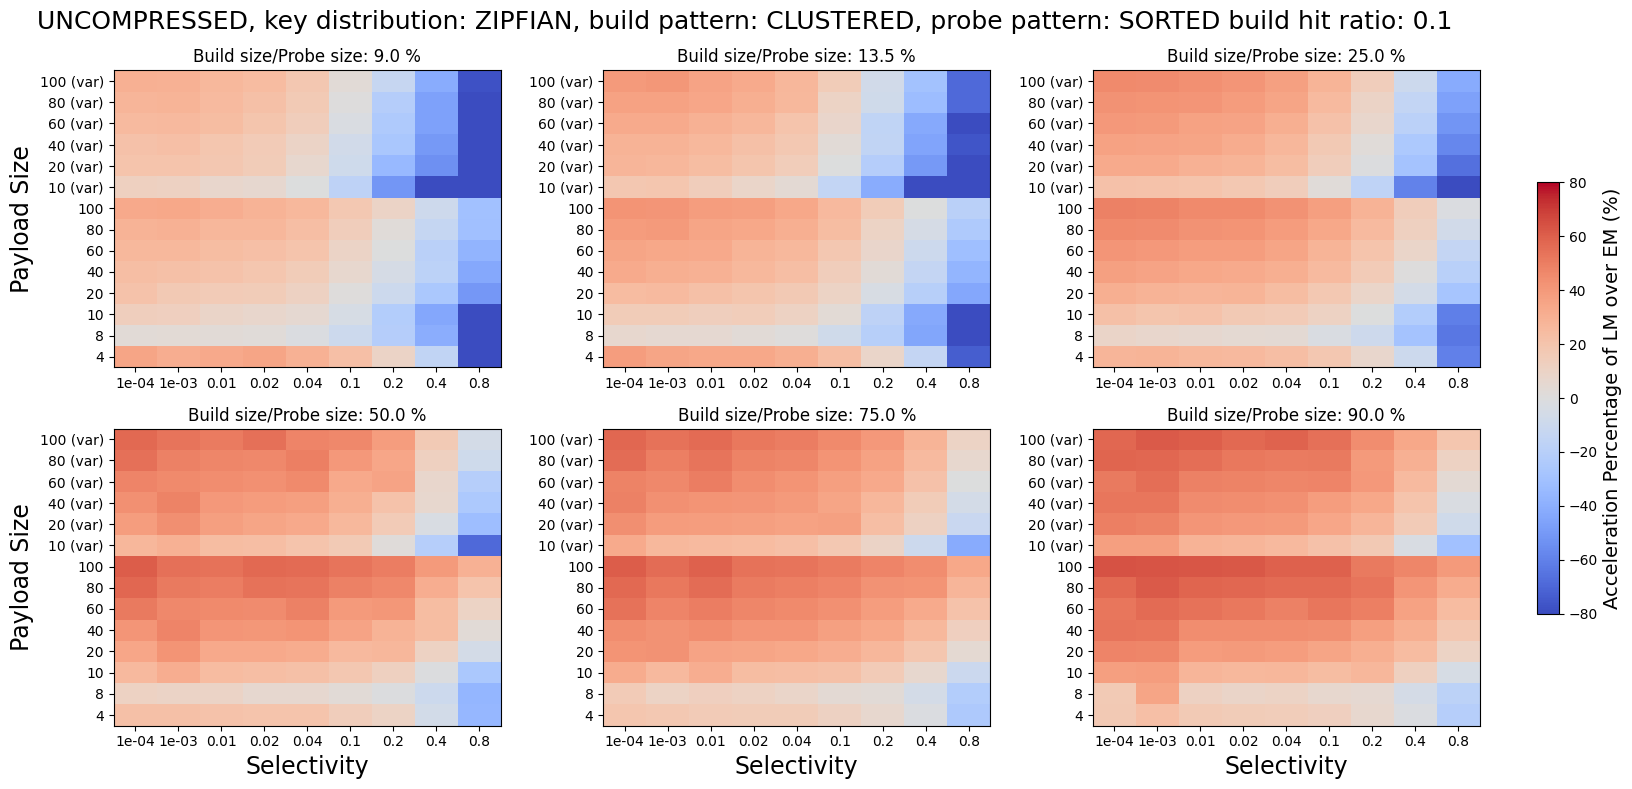

In [226]:

# 创建一个包含多个子图的图形，排成三列
num_plots = len(build_size_groups)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))


for idx, build_size in enumerate(build_size_groups):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    # only fixed length string 
    group_df = filtered_df[filtered_df['build_size'] == build_size]

    # 创建一个 NxM 的格子
    selectivities = group_df['selectivity'].unique()
    payload_sizes = group_df['payload_size'].unique()
    selectivities.sort()
    payload_sizes.sort()
    payload_sizes_new = []
    payload_number = []
    for i, payload_size in enumerate(payload_sizes):
        if payload_size<=10 or payload_size%10==0:
            payload_sizes_new.append(payload_size)
            payload_number.append(str(payload_size))
    for i, payload_size in enumerate(payload_sizes):
        if payload_size>10 and payload_size%10!=0:
            tmp_size = (payload_size//10)*10
            payload_sizes_new.append(payload_size)
            payload_number.append(str(tmp_size)+" (var)")
    payload_sizes = payload_sizes_new
    label = []
    for i, selectivity in enumerate(selectivities):
        if selectivity<0.01:
            label.append(str(format(selectivity, ".0e")))
        else:
            label.append(str(selectivity))

    # 创建颜色矩阵
    color_matrix = np.zeros((len(payload_sizes), len(selectivities)))

    for i, payload_size in enumerate(payload_sizes):
        for j, selectivity in enumerate(selectivities):
            time_1 = min_time_df[(min_time_df['selectivity'] == selectivity) & 
                                 (min_time_df['payload_size'] == payload_size) & (min_time_df['build_size'] == build_size)]['time'].min()
            time_0 = group_df[(group_df['selectivity'] == selectivity) & 
                              (group_df['payload_size'] == payload_size) & 
                              (group_df['mat_strat'] == "0")]['time'].min()
            if pd.notna(time_1) and pd.notna(time_0):
                color_matrix[i, j] = (time_0-time_1)/time_0 * 100
                # print(selectivities[j], payload_sizes[i], color_matrix[i, j])

    # 绘制颜色矩阵
    norm = Normalize(vmin=-80, vmax=80)
    c = ax.pcolormesh(label, payload_number, color_matrix, cmap='coolwarm', shading='auto',norm=norm)

    if col==0:
        ax.set_ylabel('Payload Size',fontsize=17)
    if row == (num_plots//num_cols -1):
        ax.set_xlabel('Selectivity',fontsize=17)

    ax.set_title(f'Build size/Probe size: {build_size/200000} %')


cbar = fig.colorbar(c, ax=axes, orientation='vertical',anchor=(2.4,0.5), shrink=0.7)
cbar.set_label('Acceleration Percentage of LM over EM (%)',fontsize=14)
for idx in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes.flatten()[idx])
    
title = f'key distribution: {fil_probe_distribution.upper()}, build pattern: {fil_build_key_pattern.upper()}, probe pattern: {fil_probe_key_pattern.upper()}'
if fil_build_side_hit_ratio!=1:
    title+=f' build hit ratio: {fil_build_side_hit_ratio}'
if fil_mode==1:
    title = 'UNCOMPRESSED, '+title
else:
    title = 'COMPRESSED, '+title

fig.suptitle(title, fontsize=18)
plt.tight_layout()
plt.show()

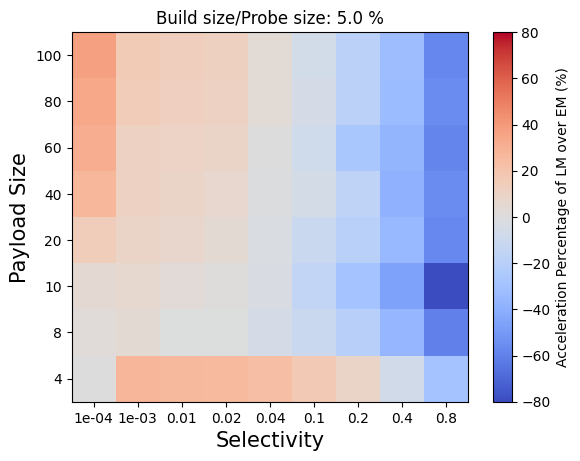

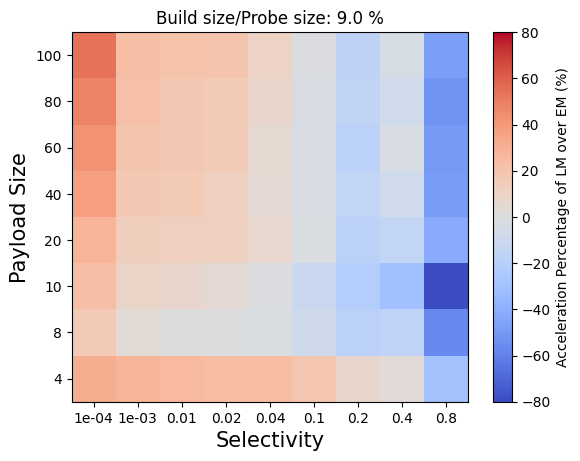

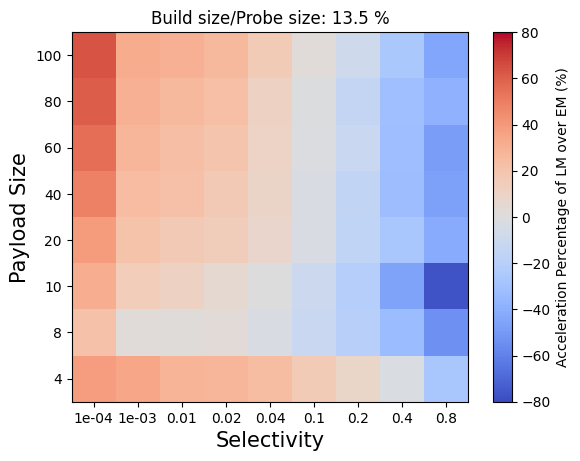

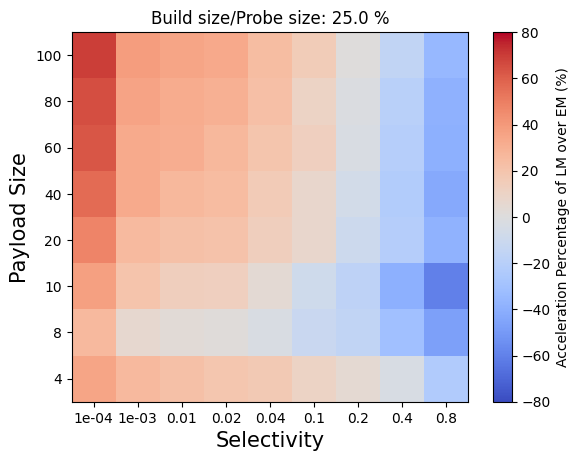

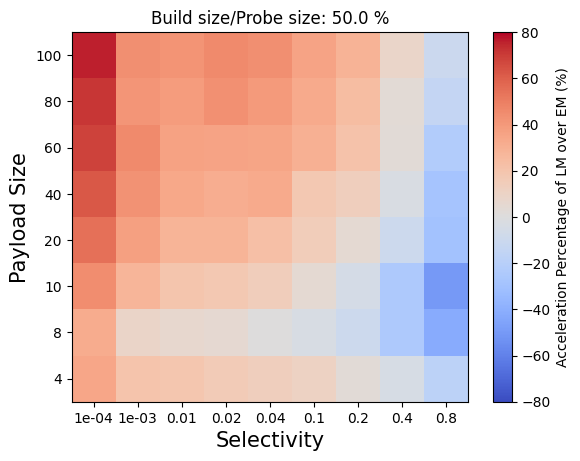

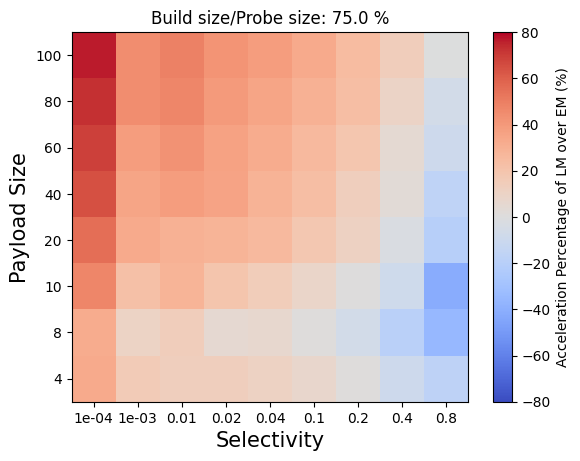

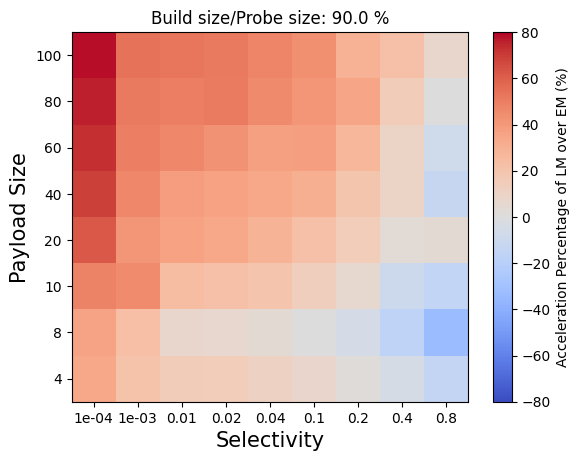

In [195]:
# 绘制图表

for build_size in build_size_groups:
    # only fixed length string 
    group_df = filtered_df[filtered_df['build_size'] == build_size]
    fig, ax = plt.subplots()

    # 创建一个 NxM 的格子
    selectivities = group_df['selectivity'].unique()
    payload_sizes = group_df['payload_size'].unique()
    selectivities.sort()
    payload_sizes.sort()
    payload_sizes_new = []
    payload_number = []
    for i, payload_size in enumerate(payload_sizes):
        if payload_size<=10 or payload_size%10==0:
            payload_sizes_new.append(payload_size)
            payload_number.append(str(payload_size))
    payload_sizes = payload_sizes_new
    label = []
    for i, selectivity in enumerate(selectivities):
        if selectivity<0.01:
            label.append(str(format(selectivity, ".0e")))
        else:
            label.append(str(selectivity))

    # 创建颜色矩阵
    color_matrix = np.zeros((len(payload_sizes), len(selectivities)))

    for i, payload_size in enumerate(payload_sizes):
        for j, selectivity in enumerate(selectivities):
            time_1 = min_time_df[(min_time_df['selectivity'] == selectivity) & 
                                 (min_time_df['payload_size'] == payload_size) & (min_time_df['build_size'] == build_size)]['time'].min()
            time_0 = group_df[(group_df['selectivity'] == selectivity) & 
                              (group_df['payload_size'] == payload_size) & 
                              (group_df['mat_strat'] == "0")]['time'].min()
            if pd.notna(time_1) and pd.notna(time_0):
                color_matrix[i, j] = (time_0-time_1)/time_0 * 100
                # print(selectivities[j], payload_sizes[i], color_matrix[i, j])

    # 绘制颜色矩阵
    norm = Normalize(vmin=-80, vmax=80)
    c = ax.pcolormesh(label, payload_number, color_matrix, cmap='coolwarm', shading='auto',norm=norm)
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('Acceleration Percentage of LM over EM (%)')


    ax.set_xlabel('Selectivity',fontsize=15)
    ax.set_ylabel('Payload Size',fontsize=15)
    ax.set_title(f'Build size/Probe size: {build_size/200000} %')


    plt.show()